## 1. INGESTA

La ingesta es el proceso mediante el cual se obtienen los datos desde cualquier fuente para ser analizados.<br>
Algunos ejemplos de orrígenes de datos son:<br>
* Bases de datos<br>
* Archivos planos(csv, txt)<br>
* Imágenes<br>

En este caso se va a trabajar con un csv que se encuentra en la url https://topcs.blob.core.windows.net/public/FlightData.csv<br>

Para eso se descarga el csv mediante una descarga web, para eso se utiliza el comando "curl" que puede ser utilizado tanto en una terminal unix como windows. <br>
    curl <b>"url de la descarga"</b> -<b>"opción(-o= output)"</b> <b>"nombre del archivo"</b>

In [5]:
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv


% Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 43 1552k   43  671k    0     0   585k      0  0:00:02  0:00:01  0:00:01  585k
100 1552k  100 1552k    0     0  1068k      0  0:00:01  0:00:01 --:--:-- 1068k


Se importa el archivo csv utilizando la librería pandas y para validar se implimen los primeros 5 registros utilizando la función de pandas <b>head()</b>

In [46]:
import pandas as pd

df = pd.read_csv('flightdata.csv')
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


## 2. PROCESS

En la etapa de procesamiento se limpian los datos, no es extraño dedicar el 80% o más del tiempo en esta fase.
Dependiendo de la necesidad se pueden eliminar valores nulo o inclusive rellenar tomando en cuenta alguna regla de negocio.<br>
Esta etapa es la base para generar modelos y anális congurentes ya que datos sucios pueden afectar los resultados obtenidos<br>
"Basura entra, basura sale"<br>
Para explorar la data pandas nos provee de muchas funciones, por ejemplo para consultar la cantidad de registros y de columnas que contiene el csv se puede puede utilizar <b>shape</b>.



In [9]:
df.shape

(11231, 26)

Esto nos ayuda a validar que toda la información que contiene el archivo fue importada exítosamente o si de lo contrario hay un faltante.
Como se comentó antes, es importante descubrir si algún valor nos puede afectar el resultado del análisis, es muy común encontrar valores nulos o valores <b>outliers</b> conocidos como valores fuera del rango.</br>
En este caso para validar si existen valores nulos podemos utilizar la función de pandas <b>isnull()</b> que cumple dicho propósito.

In [11]:
df.isnull().values.any()

True

Utilizando la misma función de pandas pero con una combinación diferente, podemos detectar cuales columnas son las que cuentan con una mayor cantidad de valores nulos.

In [13]:
df.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

Se puede apreciar que algunas columnas tienen valores nulos, pero se pueden eliminar ya que esas columnas no condicionan el modelo.

In [47]:
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

Como resultado vemos que solamente queda una columna con valores nulos, dónde esos valores pueden ser modificados, en este caso dichos valores corresponden a vuelos cancelados, que pueden ser considerados como vuelos tardíos. Por este motivo se les asigna el valor 1.

In [48]:
df = df.fillna({'ARR_DEL15': 1})
df.iloc[177:185]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,1.0
178,1,9,6,DTW,JFK,1527,0.0
179,1,10,7,MSP,DTW,1348,1.0
180,1,10,7,DTW,MSP,1540,0.0
181,1,10,7,JFK,ATL,1325,0.0
182,1,10,7,JFK,ATL,610,0.0
183,1,10,7,JFK,SEA,1615,0.0
184,1,10,7,MSP,DTW,625,1.0


In [19]:
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,1905,0.0
1,1,1,5,DTW,MSP,1345,0.0
2,1,1,5,ATL,SEA,940,0.0
3,1,1,5,SEA,MSP,819,0.0
4,1,1,5,SEA,DTW,2300,0.0


Tener valores de variables muy dispersos puede probocar que el modelo de machine learning no funcione correctamente cómo es el caso de la columna CRS_DEP_TIME. Para ellos se pueden normalizar los datos aplicando alguna función para todos los datos. Normalizar los casos consiste en "comprimir" los datos para que el modelo logre interpretar los patrones con menos esfuerzo.
En este caso se van a utilizar las funciones <b>iloc</b> de pandas

In [49]:
import math

for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


Todos los modelos de machine learning necesitan que los valores de la columnas sean numéricos, por esta razón se deben convertir todos los valores categóricos por valores numéricos.
Para ellos pandas ofrece una función llamada <b>get_dummies</b>. Esta función crea nuevas columnas según sea la cantidad de valores diferentes de la columna original, si la columna cuenta con 4 valores se crearán 4 columnas nuevas, dónde el valor en la columna que corresponde con el valor inicial se asigna 1 y a las demás 0

In [50]:
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head() 

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


## 3. PREDICT

Para realizar un modelo de predicción es necesario tener datos de entrenamiento y datos de prueba. Tomando como referencia el dataset que ya tenemos y que se acaba de trabajar,podemos utilizar <b>sklearn</b> que cuenta con funciones para separa los datos de entrenamiento y de test a partir del dataset original A parte de eso se debe separar el valor a predecir de lo valores independientes.

In [51]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

Con la función train_test_split se asigno un 20% del total de registros para validar luego el modelo.

Teniendo ambos datasets se puede proceder a entrenar el modelo, en este caso se realiza un modelo de clasificación random forest que corresponde a un árbol decisión.

In [52]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

RandomForestClassifier(random_state=13)

Entrenando nuestro modelo se procede a predecir y evaluar.

In [53]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.8642634623943035

Con dicho resultado podemos concluir que el modelo cuenta con un 80% de precision. Sin embargo para los modelos de clasificación es necesario realizar una doble validación. EN este caso se utilizará la función <b>roc_auc_score</b> de sklearn para generar la curva roc para medir la sensibilidad.

In [54]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)
roc_auc_score(test_y, probabilities[:, 1])

0.7014819895830565

El resultado no es tan bueno como el resultado anterior, esto se debe a que los datos están imbalanceados ya que hay muchos más vuelos a tiempo que los que fueron cancelados o tardíos. Otro método de validación es generar la mariz de confusión.

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[1903,   33],
       [ 272,   39]], dtype=int64)

In [56]:
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

1.0

In [57]:
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)

0.9992012779552716

## 4. VISUALIZE

Para comprender mejor los datos muchas veces es necesario representar los resultados de forma gráfica, para lograr esto python cuenta con librerías como <b>Matplotlib</b> 

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Graficando los resultados de la curva roc vemos que hay concordancia con los resultados previos dónde el módelo logra predecir los vuelos que llegan a tiempo correctamente.

Text(0, 0.5, 'True Positive Rate')

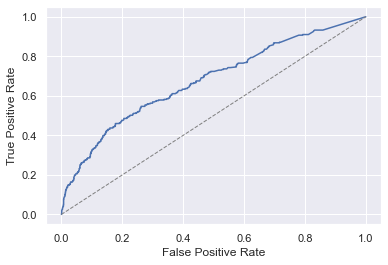

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Función para predecir nuevos valores 

In [59]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)
    
    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour
    
    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

In [60]:
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')

0.88

Con la siguiente representación se puede preveer la posibilidad de que los vuelos lleguen a tiempo o en su defecto que lleguen atrasados.

(0.0, 1.0)

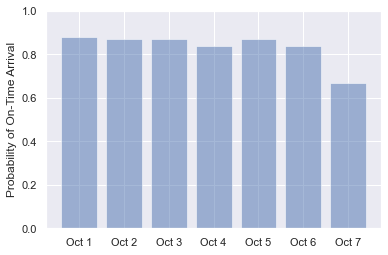

In [61]:
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))